In [2]:
from iterator import SmartIterator
from utils.visualization_utils import get_att_map, objdict, get_dict, add_attention, add_bboxes, get_bbox_from_heatmap, add_bbox_to_image
from keras.models import load_model
from old_models import ReferringRelationshipsModel
from keras.utils import to_categorical
import numpy as np
import os
from PIL import Image
import json
import matplotlib
import matplotlib.pyplot as plt
import h5py
from keras.models import Model
import seaborn as sns
from scipy.misc import imresize

matplotlib.rcParams.update({'font.size': 34})
%matplotlib inline
%load_ext autoreload
%autoreload 2

# VRD


In [6]:
###################
data_type = "vrd"
###################
if data_type=="vrd":
    #annotations_file = "/data/chami/ReferringRelationships/data/VRD/vrd_rels_multiple_objects.json"
    annotations_file = "data/VRD/annotations_test.json"
    img_dir = '/data/chami/VRD/sg_dataset/sg_test_images/'
    vocab_dir = os.path.join('data/VRD')
    model_checkpoint = "/data/chami/tmp/model19-2.09.h5"
    #model_checkpoint ="/data/chami/ReferringRelationships/models/VRD/11_09_2017/baseline_no_predicate/1/model26-1.68.h5"
    #model_checkpoint= "/data/ranjaykrishna/ReferringRelationships/temp/vrd_iter1/model29-1.41.h5"
    #model_checkpoint = "/data/chami/ReferringRelationships/models/VRD/11_09_2017/baseline/1/model21-1.59.h5"
    #model_checkpoint= "/data/chami/ReferringRelationships/models/VRD/11_07_2017/baseline_no_predicate/8/model24-1.38.h5"
elif data_type=="clevr":
    annotations_file = "data/clevr/annotations_test.json"
    img_dir = '/data/ranjaykrishna/clevr/images/test'
    vocab_dir = os.path.join('data/clevr')
    model_checkpoint = "/data/ranjaykrishna/ReferringRelationships/temp/"
elif data_type=="visualgenome":
    annotations_file = "data/VisualGenome/annotations_test.json"
    img_dir = '/data/chami/VRD/sg_dataset/sg_test_images/'
    vocab_dir = os.path.join('data/VisualGenome')
    model_checkpoint = "/data/ranjaykrishna/ReferringRelationships/temp/"

### Setup

In [7]:
annotations_test = json.load(open(annotations_file))
predicate_dict, obj_subj_dict = get_dict(vocab_dir)
image_ids = sorted(list(annotations_test.keys()))[:1000]
params = objdict(json.load(open(os.path.join(os.path.dirname(model_checkpoint), "args.json"), "r")))
params.norm_scale=1
params.use_internal_loss = False
relationships_model = ReferringRelationshipsModel(params)
test_generator = SmartIterator(params.test_data_dir, params)
images = test_generator.get_image_dataset()
print(' | '.join(obj_subj_dict))
print('')
print(' | '.join(predicate_dict))

person | sky | building | truck | bus | table | shirt | chair | car | train | glasses | tree | boat | hat | trees | grass | pants | road | motorcycle | jacket | monitor | wheel | umbrella | plate | bike | clock | bag | shoe | laptop | desk | cabinet | counter | bench | shoes | tower | bottle | helmet | stove | lamp | coat | bed | dog | mountain | horse | plane | roof | skateboard | traffic light | bush | phone | airplane | sofa | cup | sink | shelf | box | van | hand | shorts | post | jeans | cat | sunglasses | bowl | computer | pillow | pizza | basket | elephant | kite | sand | keyboard | plant | can | vase | refrigerator | cart | skis | pot | surfboard | paper | mouse | trash can | cone | camera | ball | bear | giraffe | tie | luggage | faucet | hydrant | snowboard | oven | engine | watch | face | street | ramp | suitcase

on | wear | has | next to | sleep next to | sit next to | stand next to | park next | walk next to | above | behind | stand behind | sit behind | park behind | in 

### Load the model.

In [8]:
model = relationships_model.build_model()
model.load_weights(model_checkpoint)

In [9]:
def get_layers(name, offset=0):
    attentions = []
    while True:
        layer_name = name.format(len(attentions) + offset)
        try:
            heatmap = model.get_layer(layer_name).output
            attentions.append(heatmap)
        except:
            break
    return attentions

subject_attentions = get_layers("subject-att-{}")
object_attentions = get_layers("object-att-{}")
shift_attentions = get_layers("shift-{}", offset=1)
inv_shift_attentions = get_layers("inv-shift-{}", offset=1)

print("Found {} subject attentions".format(len(subject_attentions)))
print("Found {} object attentions".format(len(object_attentions)))
print("Found {} shift attentions".format(len(shift_attentions)))
print("Found {} inv shift attentions".format(len(inv_shift_attentions)))

all_attentions = subject_attentions + object_attentions + shift_attentions + inv_shift_attentions
attention_model = Model(inputs=model.input, outputs=all_attentions)

Found 3 subject attentions
Found 3 object attentions
Found 2 shift attentions
Found 2 inv shift attentions


### USER INPUT - Pick an image 

19


(-0.5, 223.5, 223.5, -0.5)

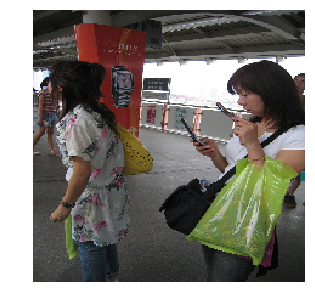

In [73]:
#################
image_index = np.random.randint(100)
print(image_index)
#################
img = Image.open(os.path.join(img_dir, image_ids[image_index]))
img = img.resize((params.input_dim, params.input_dim))
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis("off")

### USER INPUT - Pick a relationship 

In [74]:
#################
subj = "person"
predicate = "on the right of"
obj = "person"
#################
subj_id = np.zeros((1, 1))
predicate_id = np.zeros((1, params.num_predicates))
#predicate_id = np.zeros((1, 1))
obj_id = np.zeros((1, 1))
relationship = [subj, predicate, obj]
subj_id[0, 0] = obj_subj_dict.index(subj)
predicate_id[0, predicate_dict.index(predicate)] = 1
#predicate_id[0, 0] = predicate_dict.index(predicate)
obj_id[0, 0] = obj_subj_dict.index(obj)

### Run the model and visualize the heatmaps.

In [75]:
all_heatmaps = model.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id])
#all_heatmaps = model.predict([images[image_index:image_index+1], subj_id, obj_id])

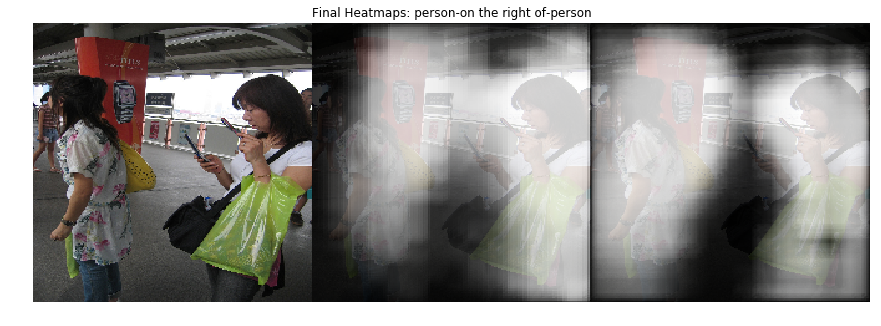

In [76]:
att_map = get_att_map(img, np.maximum(all_heatmaps[0],0), np.maximum(all_heatmaps[1],0), params.input_dim, relationship)
plt.figure(figsize=(15, 15))
plt.imshow(att_map)
plt.title("Final Heatmaps: " + "-".join(relationship))
plt.axis("off")
plt.show()

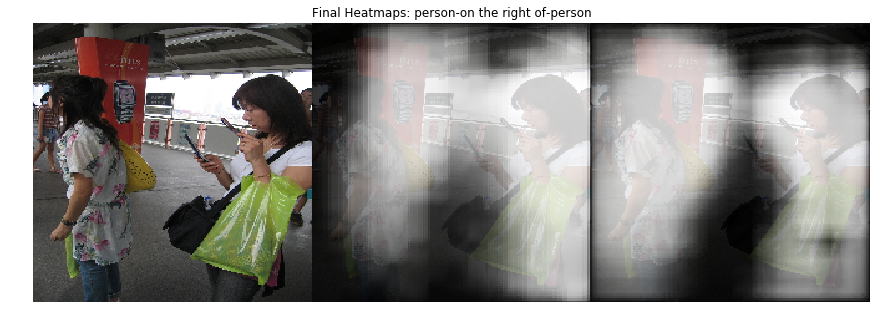

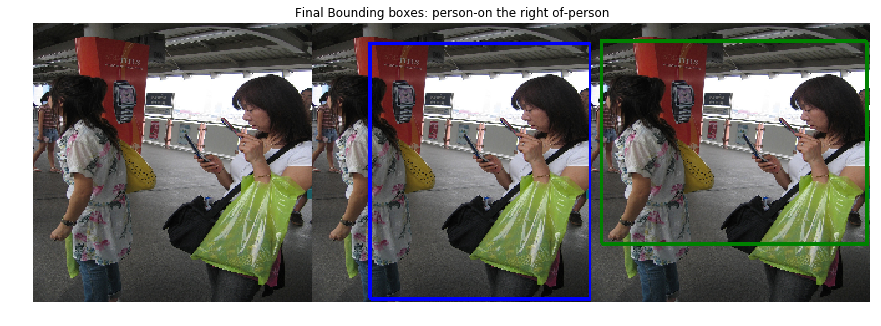

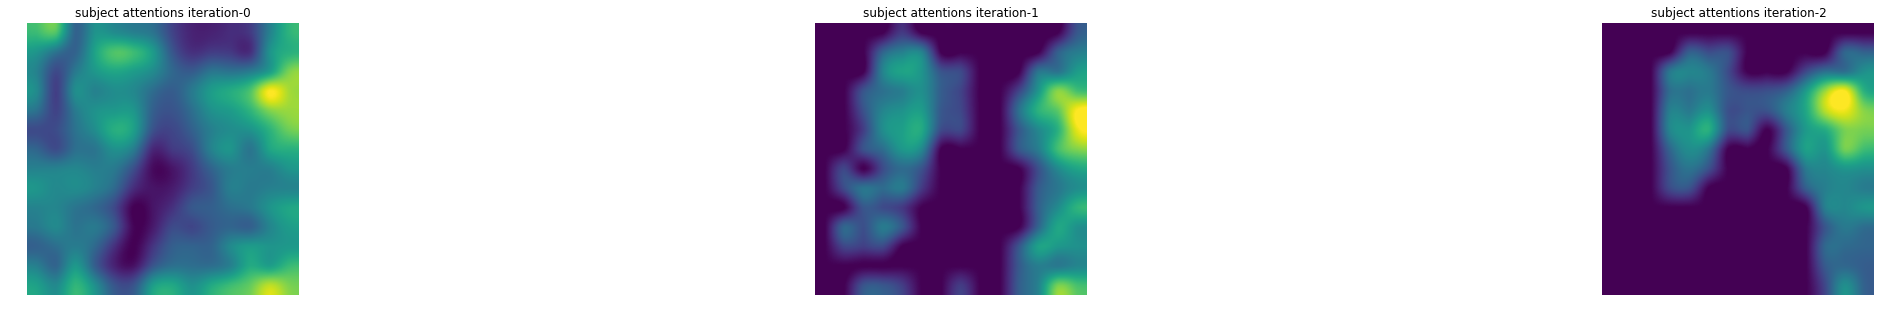

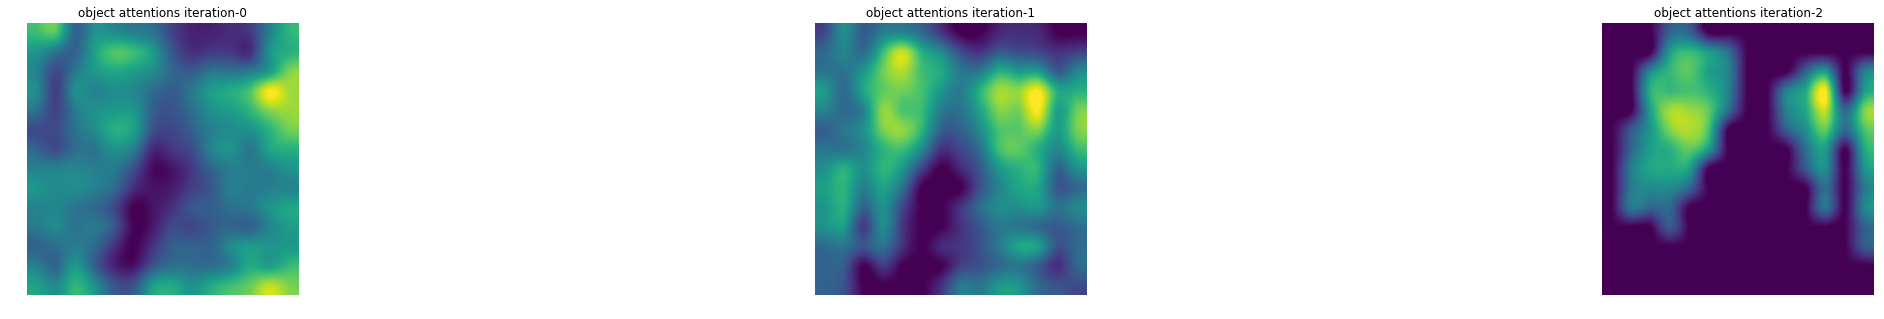

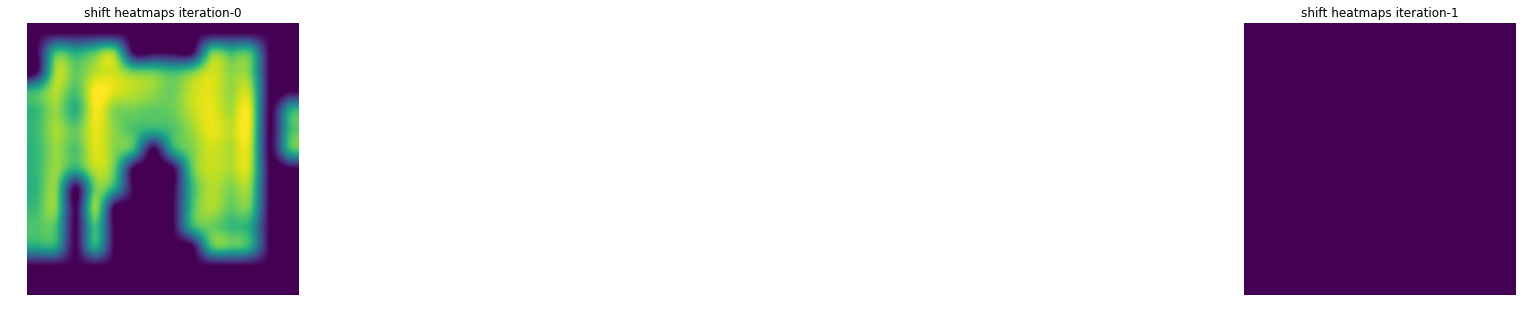

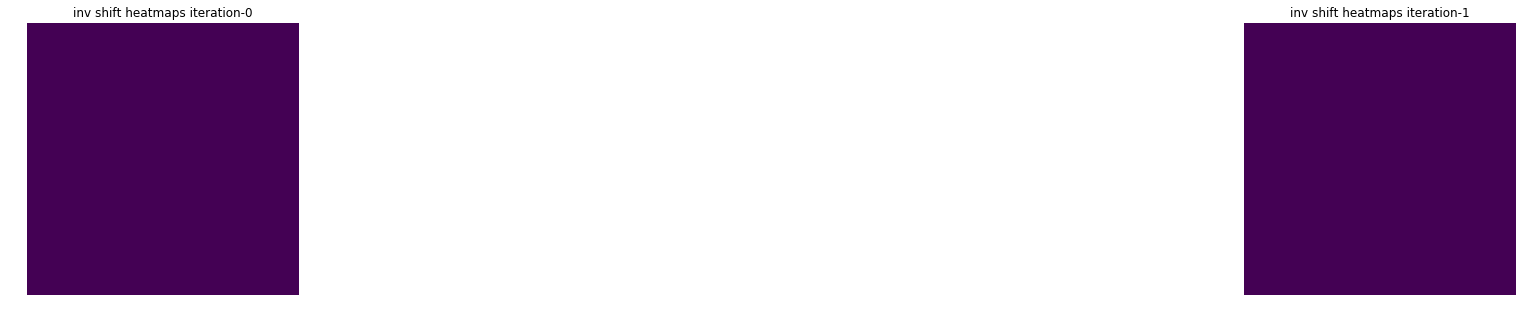

In [77]:
# Get all the predictions we want to visualize
all_heatmaps = attention_model.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id])
all_heatmaps = attention_model.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id])
subject_heatmaps = all_heatmaps[0:len(subject_attentions)]
object_heatmaps = all_heatmaps[len(subject_attentions):len(subject_attentions)+len(object_attentions)]
shift_heatmaps = all_heatmaps[len(subject_attentions)+len(object_attentions):len(subject_attentions)+len(object_attentions)+len(shift_attentions)]
inv_shift_heatmaps = all_heatmaps[len(subject_attentions)+len(object_attentions)+len(shift_attentions):len(subject_attentions)+len(object_attentions)+len(shift_attentions)+len(inv_shift_attentions)]
final_subject_heatmap, final_object_heatmap = model.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id])

# Visualize heatmaps
att_map = get_att_map(img, np.maximum(final_subject_heatmap[0],0), np.maximum(final_object_heatmap[0],0), params.input_dim, relationship)
plt.figure(figsize=(15, 15))
plt.imshow(att_map)
plt.title("Final Heatmaps: " + "-".join(relationship))
plt.axis("off")
plt.show()

# Visualize bounding boxes.
att_map = add_bboxes(img, np.maximum(final_subject_heatmap[0],0), 
                     np.maximum(final_object_heatmap[0],0), params.input_dim, threshold=0.8)
plt.figure(figsize=(15, 15))
plt.imshow(att_map)
plt.title("Final Bounding boxes: " + "-".join(relationship))
plt.axis("off")
plt.show()

# Visualize attention over iterations.
def display_attention_heatmaps(heatmaps, title):
    fig, axs = plt.subplots(nrows=1, ncols=len(heatmaps), figsize=(40,5))
    for idx in range(len(heatmaps)):
        ax = axs[idx]
        #att = add_attention(img, np.maximum(heatmaps[idx],0), params.input_dim)
        att = heatmaps[idx].reshape((params.feat_map_dim, params.feat_map_dim))
        att[att < np.max(params.heatmap_threshold)] = 0
        ax.imshow(att, interpolation='spline16')
        #sns.heatmap(att, annot=True, linewidths=.5, ax=ax)
        ax.set_title(title + ' iteration-{}'.format(idx))
        ax.axis("off")
    plt.show()

display_attention_heatmaps(subject_heatmaps, 'subject attentions')
display_attention_heatmaps(object_heatmaps, 'object attentions')
display_attention_heatmaps(shift_heatmaps, 'shift heatmaps')
display_attention_heatmaps(inv_shift_heatmaps, 'inv shift heatmaps')

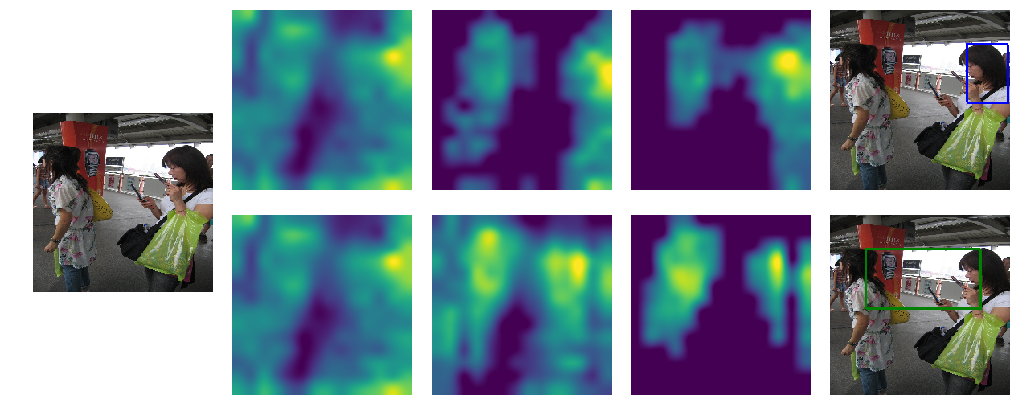

In [80]:
# Visualizations for the paper.
#############################
iterations_to_show = 3
threshold = 0.99
#############################
ncols = iterations_to_show*2 + 4
nrows = 4
fig = plt.figure(figsize=(14, 6))

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=2, rowspan=2)
ax.imshow(img)
ax.axis("off")

s_bbox = get_bbox_from_heatmap(final_subject_heatmap[0], threshold=threshold)
s_image = add_bbox_to_image(img, s_bbox, color='blue', width=3)
ax = plt.subplot2grid((nrows, ncols), (0, iterations_to_show*2+2), colspan=2, rowspan=2)
ax.imshow(s_image)
ax.axis("off")

o_bbox = get_bbox_from_heatmap(final_object_heatmap[0], threshold=threshold)
o_image = add_bbox_to_image(img, o_bbox, color='green', width=3)
ax = plt.subplot2grid((nrows, ncols), (2, iterations_to_show*2+2), colspan=2, rowspan=2)
ax.imshow(o_image)
ax.axis("off")

for iteration in range(iterations_to_show):
    s_att = subject_heatmaps[iteration].reshape((params.feat_map_dim, params.feat_map_dim))
    s_att[s_att < np.max(params.heatmap_threshold)] = 0
    ax = plt.subplot2grid((nrows, ncols), (0, 2*iteration+2), colspan=2, rowspan=2)
    ax.imshow(s_att, interpolation='spline16')
    ax.axis("off")
                          
    o_att = object_heatmaps[iteration].reshape((params.feat_map_dim, params.feat_map_dim))
    o_att[o_att < np.max(params.heatmap_threshold)] = 0
    ax = plt.subplot2grid((nrows, ncols), (2, 2*iteration+2), colspan=2, rowspan=2)
    ax.imshow(o_att, interpolation='spline16')
    ax.axis("off")
    
plt.tight_layout(pad=0.1, w_pad=-1, h_pad=-2)

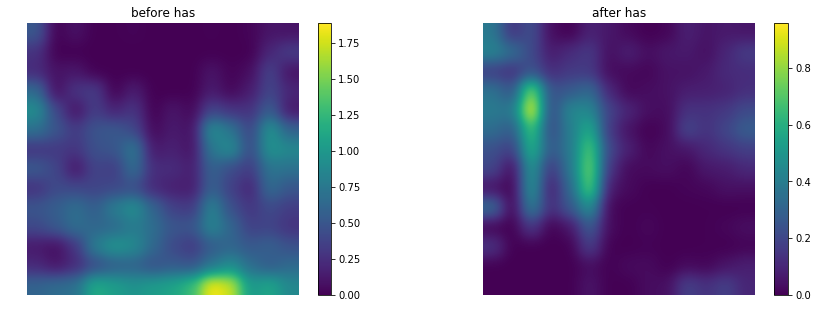

In [63]:
output = model.get_layer("subject-att-1").output
before_pred = Model(inputs=model.input, outputs=output)
output = model.get_layer("object-att-1").output
after_pred = Model(inputs=model.input, outputs=output)
output = model.get_layer("shift-1").output
shift = Model(inputs=model.input, outputs=output)
interp_method = 'gaussian'
map_1 = before_pred.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id])
map_2 = after_pred.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id])
map_3 = shift.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id])
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
img_1 = map_1.reshape((params.feat_map_dim, params.feat_map_dim))
plot0 = axes[0].imshow(img_1, interpolation=interp_method)
plot1 = axes[1].imshow(map_2.reshape((params.feat_map_dim, params.feat_map_dim)), interpolation=interp_method)
fig.colorbar(plot0, ax=axes[0])
axes[0].axis("off")
axes[0].set_title("before {}".format(predicate))
axes[1].axis("off")
axes[1].set_title("after {}".format(predicate))
fig.colorbar(plot1, ax=axes[1])

Text(0.5,1,'after-pred above')

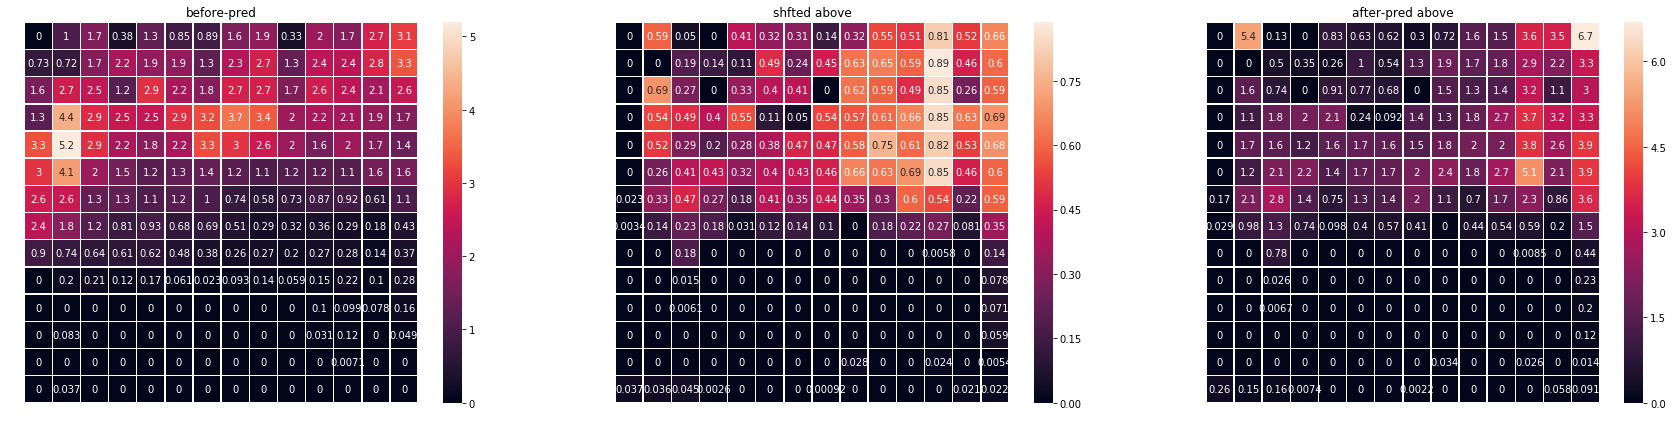

In [54]:
map_1 = before_pred.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id]).reshape((params.feat_map_dim, params.feat_map_dim))
map_2 = after_pred.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id]).reshape((params.feat_map_dim, params.feat_map_dim))
map_3 = shift.predict([images[image_index:image_index+1], subj_id, predicate_id, obj_id]).reshape((params.feat_map_dim, params.feat_map_dim))
fig, axes = plt.subplots(1, 3, figsize=(30, 7))
sns.heatmap(map_1, annot=True, linewidths=.5, ax=axes[0])
sns.heatmap(map_3, annot=True, linewidths=.5, ax=axes[1])
sns.heatmap(map_2, annot=True, linewidths=.5, ax=axes[2])
for i in range(3):
    axes[i].axis("off")
axes[0].set_title("before-pred")
axes[1].set_title("shfted {}".format(predicate))
axes[2].set_title("after-pred {}".format(predicate))

In [ ]:
model.summary()

### Image ids that I like:
678

# Clevr

In [ ]:
annotations_test = json.load(open("/data/ranjaykrishna/ReferringRelationships/data/clevr/annotations_test.json"))
test_data_dir = '/data/ranjaykrishna/ReferringRelationships/data/dataset-clevr-small/test/'
img_dir = '/data/ranjaykrishna/clevr/images/val/'
vocab_dir = '/data/chami/ReferringRelationships/data/Clevr/'
model_checkpoint = "/data/chami/ReferringRelationships/models/Clevr/10_14_2017/2/model04-0.13.h5"
predicate_dict, obj_subj_dict = get_dict(vocab_dir)
image_ids = sorted(list(annotations_test.keys()))[:1000]
params = objdict(json.load(open(os.path.join(os.path.dirname(model_checkpoint), "args.json"), "r")))
params.use_internal_loss = False
params.categorical_predicate = False
#relationships_model = ReferringRelationshipsModel(params)
test_generator = SmartIterator(test_data_dir, params)
images = test_generator.get_image_dataset()
subj_id = np.zeros((1, 1))
predicate_id = np.zeros((1, params.num_predicates))
obj_id = np.zeros((1, 1))

In [ ]:
#################
image_index = 0 
#################
import seaborn as sns
cmap_2 = sns.cubehelix_palette(8, start=2, rot=0, dark=0.3, light=.95, reverse=True, as_cmap=True)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
img = Image.open(os.path.join(img_dir, image_ids[image_index]))
img = img.resize((params.input_dim, params.input_dim))
axes[0].imshow(img)
axes[0].axis("off")
axes[0].set_title("Original image")
axes[1].imshow(255*test_generator[0][1][0][0].reshape(224,224),cmap=cmap_2)
axes[1].axis("off")
axes[1].set_title("Subject bounding box")
axes[2].imshow(255*test_generator[0][1][1][0].reshape(224,224),cmap=cmap_2)
axes[2].axis("off")
axes[2].set_title("Object bounding box")